In [1]:
%matplotlib inline

In [26]:
import csv
import pandas as pd
import numpy as np
import os
from datetime import datetime
import calendar

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import linregress

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')



In [3]:
# Global declarations
data_path = "..\data"

#dataFile = "AvgTempCYear_1.csv"
dataFile = "NaN_Replaced_Temps.csv"

#Output folders
result_dir = "..\output"
image_dir = "..\images"

# Plot Style to use
mpl.style.use('seaborn')




In [4]:
#read data file
tempDF = pd.read_csv(os.path.join(data_path, dataFile))

tempDF.head()

,Country,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,ALGERIA,1975,8.9,10.3,12.1,16.4,20.7,23.8,28.5,27.8,24.7,18.9,12.8,10.9
1,ALGERIA,1976,8.6,10.6,11.3,15.8,19.7,24.9,27.5,25.0,24.2,19.0,11.7,11.1
2,ALGERIA,1977,11.0,12.4,14.8,16.9,20.0,23.0,28.7,26.0,24.0,19.4,14.0,11.7
3,ALGERIA,1978,9.1,13.1,13.8,16.9,20.0,25.1,28.1,27.8,24.8,17.8,12.6,12.9
4,ALGERIA,1979,13.0,12.1,14.4,15.0,21.0,26.5,29.3,29.2,23.8,20.0,11.5,10.2


In [5]:
#check for missing values
print(f"Missing values total - {tempDF.isnull().values.sum()}")

#mising rows
nullRows = tempDF[tempDF.isnull().any(axis = 1)]

print(f"Number of rows ith missing data : {nullRows.count()}")


Missing values total - 0
Number of rows ith missing data : Country    0
Year       0
Jan        0
Feb        0
Mar        0
Apr        0
May        0
Jun        0
Jul        0
Aug        0
Sep        0
Oct        0
Nov        0
Dec        0
dtype: int64


,Country,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec


In [6]:
# NOt required ----
# fill the NA with rowwise means
#rowMeans = tempDF[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].mean(axis = 1)
#rowMeans

#tempDF = tempDF.apply(lambda r: r.fillna(rowMeans[r.index]))

In [7]:
#print(f"Missing values total - {tempDF.isnull().values.sum()}")

Missing values total - 0


## START ANALYSIS

In [8]:
# Reshape Temp data, such that months are in rows and data col is added
# USE melt() to change the column-wise months into row-wse data

temp_flatDF = pd.melt(tempDF, id_vars =['Country','Year'], var_name = 'Month', value_name = "Monthly_Temp")

temp_flatDF.head()

,Country,Year,Month,Monthly_Temp
0,ALGERIA,1975,Jan,8.9
1,ALGERIA,1976,Jan,8.6
2,ALGERIA,1977,Jan,11.0
3,ALGERIA,1978,Jan,9.1
4,ALGERIA,1979,Jan,13.0


In [28]:
#Convert month names to month number
month_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

temp_flatDF['Month_Num'] = temp_flatDF['Month'].apply(lambda r: month_num[r] )

# Add Date column, example 01-Jan-1975
temp_flatDF['Date'] = temp_flatDF['Year'].astype(str)+'-'+temp_flatDF['Month'].astype(str)+'-01'
temp_flatDF['Date'] = temp_flatDF['Date'].apply(lambda r: datetime.strptime(r , '%Y-%b-%d'))

temp_flatDF.sort_values(by = ['Year','Month_Num'])


temp_flatDF.dtypes

Country                 object
Year                     int64
Month                   object
Monthly_Temp           float64
Date            datetime64[ns]
Month_Num                int64
dtype: object

### Roll up averages to global level for temp

In [29]:
# Group by year and month and aggregate values by mean()

temp_GDF_YM = temp_flatDF.groupby(['Year','Date','Month_Num']).agg(np.mean)

temp_GDF_YM.reset_index(inplace = True)


temp_GDF_YM.sort_values(by = ['Year','Month_Num'])

temp_GDF_YM.head()
#temp_GDF_YM.dtypes


,Year,Date,Month_Num,Monthly_Temp
0,1975,1975-01-01,1,12.086667
1,1975,1975-02-01,2,12.323333
2,1975,1975-03-01,3,14.375417
3,1975,1975-04-01,4,16.607500
4,1975,1975-05-01,5,18.815833


In [11]:
# Group by year aggregate values by mean()

temp_GDF_Y = temp_flatDF[['Year','Monthly_Temp']].groupby(['Year']).agg(np.mean)

temp_GDF_Y.reset_index(inplace = True)

temp_GDF_Y.head()

,Year,Monthly_Temp
0,1975,16.578437
1,1976,16.183403
2,1977,16.634201
3,1978,16.402431
4,1979,16.594826


## Perform Regression Analysis - Yearly Temp Average

In [12]:
#
# Set line
x_axis = temp_GDF_Y['Year']
y_axis = temp_GDF_Y['Monthly_Temp'] 
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
print(f"Slope of the regression line is {slope}")
print(f"p-Value of the regression line is {p_value}")

Slope of the regression line is 0.03280403763083009
p-Value of the regression line is 9.062676000950596e-20


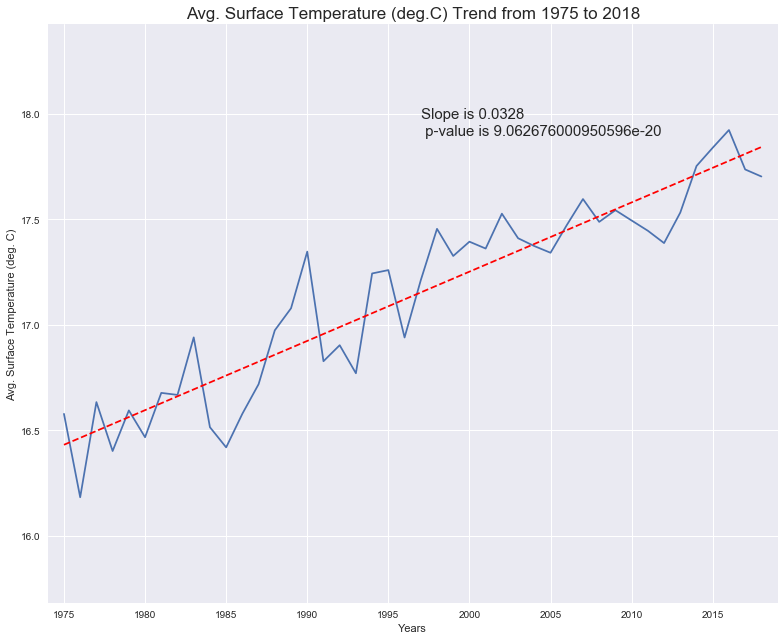

In [22]:
# Plot a simple timeseries plot
fig,ax = plt.subplots(figsize = (11,9))

ax.plot(x_axis, y_axis)
ax.plot(x_axis, fit, 'r--')

ax.set_xlim(x_axis.min()-1, x_axis.max()+1)
ax.set_ylim(y_axis.min()-0.5, y_axis.max()+0.5)

ax.set_xlabel("Years", fontsize = 11)
ax.set_ylabel("Avg. Surface Temperature (deg. C)", fontsize = 11)

ax.set_title(f"Avg. Surface Temperature (deg.C) Trend from {min(x_axis)} to {max(x_axis)}", fontsize = 17)

ax.text(1997,17.9, f"Slope is {round(slope, 4)} \n p-value is {p_value}", fontsize = 15)

plt.tight_layout()

plt.savefig(os.path.join(image_dir, "AvgTemp_regressFit.png"))

plt.show()

### Regression Analysis on Temp - MOnthly Moving Average

In [14]:
temp_movAvg_DF = temp_GDF_YM[['Date','Monthly_Temp']].rolling(window = 12, on = 'Date').mean()

#temp_movAvg_DF.set_index('Date', inplace = True)

#get year
temp_movAvg_DF['Year'] = temp_movAvg_DF['Date'].apply(lambda r : r.year)

# get time delta in months so we can how temperature varies
temp_movAvg_DF.set_index('Date', inplace = True)
timedel = (temp_movAvg_DF.index - temp_movAvg_DF.index[0])

temp_movAvg_DF['days'] = timedel.days

temp_movAvg_DF.count()
#temp_movAvg_DF.dtypes

Monthly_Temp    517
Year            528
days            528
dtype: int64

In [15]:
#
# Set line
#x_axis = temp_movAvg_DF['Year']
x_axis1 = temp_movAvg_DF['days']
y_axis1 = temp_movAvg_DF['Monthly_Temp'] 

#mask is boolean values that tells lineregress to use or ignore values
mask = ~np.isnan(x_axis1) & ~np.isnan(y_axis1)


(slope1, intercept1, r_value1, p_value1, std_err1) = linregress(x_axis1[mask], y_axis1[mask])
fit1 = slope1 * x_axis1 + intercept1
print(f"Slope of the regression line is {slope1}")
print(f"r-Value of the regression line is {r_value1}")
print(f"p-Value of the regression line is {p_value1}")

Slope of the regression line is 0.03280403763083009
r-Value of the regression line is 0.9292356226085511
p-Value of the regression line is 9.062676000950596e-20


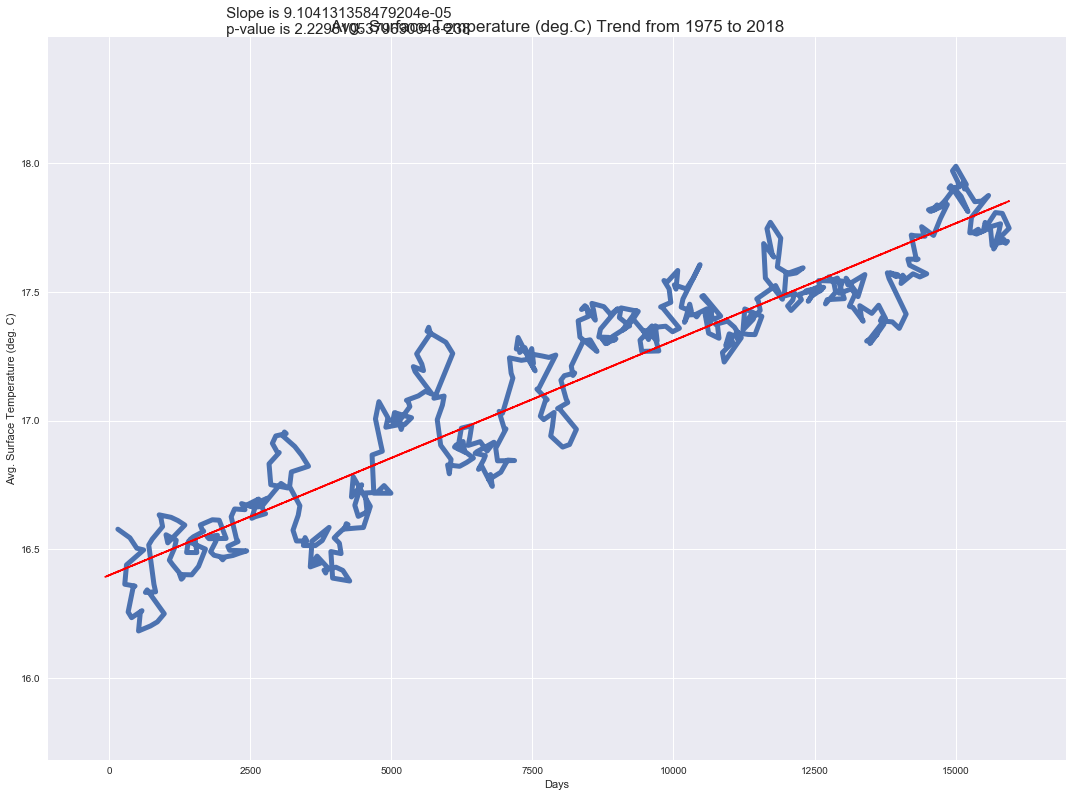

In [23]:
# Plot a simple timeseries plot
fig,ax = plt.subplots(figsize = (15,11))

ax.plot(x_axis1,y_axis1, linewidth = 5)

ax.plot(x_axis1, fit1, 'r--')

ax.set_xlim(x_axis1.min()-1000, x_axis1.max()+1000)
ax.set_ylim(y_axis1.min()-0.5, y_axis1.max()+0.5)


ax.set_xlabel("Days", fontsize = 11)
ax.set_ylabel("Avg. Surface Temperature (deg. C)", fontsize = 11)

ax.set_title(f"Avg. Surface Temperature (deg.C) Trend from {min(temp_movAvg_DF['Year'])} to {max(temp_movAvg_DF['Year'])}",\
             fontsize = 17)

ax.text(2000,18.5, f" Slope is {slope1} \n p-value is {p_value1}", fontsize = 15)

plt.tight_layout()

plt.savefig(os.path.join(image_dir, "AvgTemp_regressFit_rolling.png"))

plt.show()

### ANNOVA  Test to prove "Surface temp has risen more 0.5 degC since 1975"

4 groups are created 1975 - 1985, 1986 - 1996, 1997 - 2007, 2008 - 2017

In [17]:
# Create four Bins of Temp over years
bins = [1974, 1986, 1997, 2008,  2018]

# Create the names for the four bins
group_names = ["1975 - 1985", "1986 - 1996", "1997 - 2007", "2008 - 2017"]

In [18]:
temp_GDF_Y['TempGrps'] = pd.cut(temp_GDF_Y['Year'], bins, labels = group_names)

temp_GDF_Y.head()

,Year,Monthly_Temp,TempGrps
0,1975,16.578437,1975 - 1985
1,1976,16.183403,1975 - 1985
2,1977,16.634201,1975 - 1985
3,1978,16.402431,1975 - 1985
4,1979,16.594826,1975 - 1985


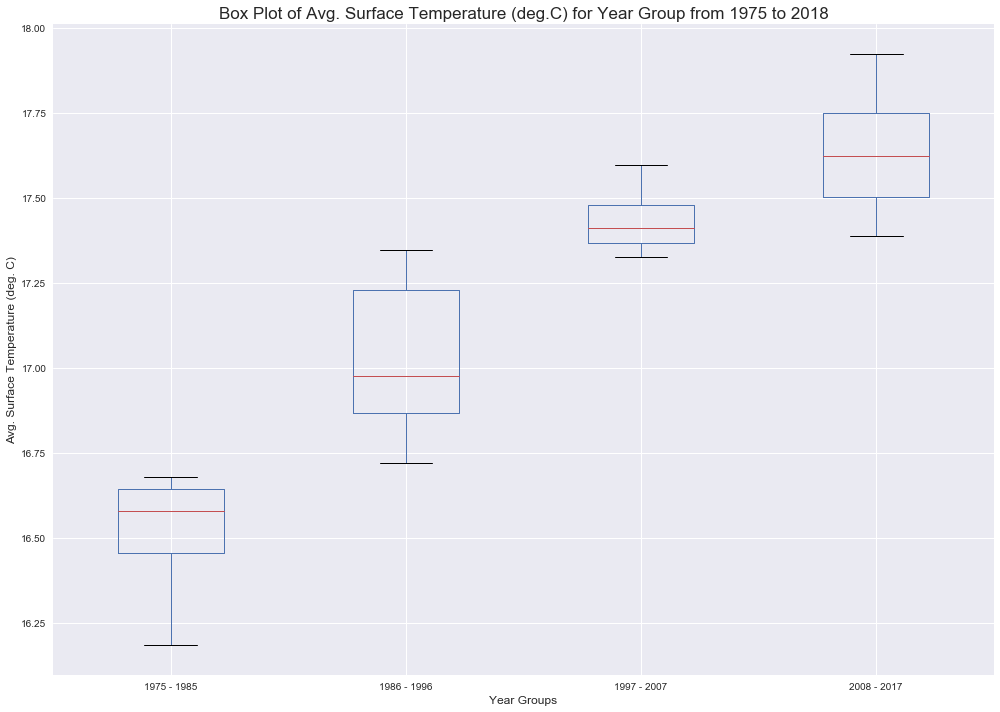

In [19]:
# Create a boxplot to see the difference in the mean
fig = temp_GDF_Y.boxplot("Monthly_Temp", by="TempGrps", figsize=(14, 10))

plt.xlabel("Year Groups", fontsize = 12)
plt.ylabel("Avg. Surface Temperature (deg. C)", fontsize = 12)

plt.title(f"Box Plot of Avg. Surface Temperature (deg.C) for Year Group from {min(x_axis)} to {max(x_axis)}", \
         fontsize = 17)

plt.suptitle("")

plt.tight_layout()

plt.savefig(os.path.join(image_dir, "AvgTemp_boxPlot.png"))

plt.show()

### Create groups for ANNOVA analysis

In [20]:
# Extract individual groups
group1 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[0]]["Monthly_Temp"]
group2 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[1]]["Monthly_Temp"]
group3 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[2]]["Monthly_Temp"]
group4 = temp_GDF_Y[temp_GDF_Y["TempGrps"] == group_names[3]]["Monthly_Temp"]


In [21]:
# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=84.8748453298956, pvalue=2.1713647641992118e-17)